In [86]:
import datetime
import sklearn
import typing as tp
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import linear_model


X_type = tp.NewType("X_type", np.ndarray)
X_row_type = tp.NewType("X_row_type", np.ndarray)
Y_type = tp.NewType("Y_type", np.array)
TS_type = tp.NewType("TS_type", pd.Series)
Model_type = tp.TypeVar("Model_type")


def read_timeseries(path_to_df: str = "train.csv") -> TS_type:
    """Функция для чтения данных и получения обучающей и тестовой выборок"""
    df = pd.read_csv(path_to_df)
    df = df[(df['store'] == 1) & (df['item'] == 1)]
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    ts = df["sales"]
    train_ts = ts[:-365]
    test_ts = ts[-365:]
    return train_ts, test_ts


def extract_hybrid_strategy_features(
    timeseries: TS_type,
    model_idx: int,
    window_size: int = 365
) -> X_row_type:
    """
    Функция для получения вектора фичей согласно гибридной схеме. На вход подаётся временной ряд
    до момента T, функция выделяет из него фичи, необходимые модели под номером model_idx для
    прогноза на момент времени T
    
    Args:
        timeseries --- временной ряд до момента времени T (не включительно), pd.Series с датой 
                       в качестве индекса
        model_idx --- индекс модели, то есть номер шага прогноза, 
                      для которого нужно получить признаки, нумерация с нуля
        window_size --- количество последних значений ряда, используемых для прогноза 
                        (без учёта количества прогнозов с предыдущих этапов)

    Returns:
        Одномерный вектор фичей для модели с индексом model_idx (np.array), 
        чтобы сделать прогноз для момента времени T
    """
    feature_window = model_idx + window_size
    return timeseries[-feature_window:].values


def build_datasets(
    timeseries: TS_type,
    extract_features: tp.Callable[..., X_row_type],
    window_size: int,
    model_count: int
) -> tp.List[tp.Tuple[X_type, Y_type]]:
    """
    Функция для получения обучающих датасетов согласно гибридной схеме
    
    Args:
        timeseries --- временной ряд
        extract_features --- функция для генерации вектора фичей
        window_size --- количество последних значений ряда, используемых для прогноза
        model_count --- количество моделей, используемых для получения предскзаний 

    Returns:
        Список из model_count датасетов, i-й датасет используется для обучения i-й модели 
        и представляет собой пару из двумерного массива фичей и одномерного массива таргетов
    """
    datasets = []

    for model_idx in range(model_count):
  
        featces = []
        targets = []
  
        for i in range(window_size + model_idx, len(timeseries)):
            featces.append(extract_features(timeseries[:i], model_idx, window_size))
            targets.append(timeseries[i])
        datasets.append((featces, targets))
    
    assert len(datasets) == model_count
    return datasets


def predict(
    timeseries: TS_type,
    models: tp.List[Model_type],
    extract_features: tp.Callable[..., X_row_type] = extract_hybrid_strategy_features
) -> TS_type:
    """
    Функция для получения прогноза len(models) следующих значений временного ряда
    
    Args:
        timeseries --- временной ряд, по которому необходимо сделать прогноз на следующие даты
        models --- список обученных моделей, i-я модель используется для получения i-го прогноза
        extract_features --- функция для генерации вектора фичей. Если вы реализуете свою функцию 
                             извлечения фичей для конечной модели, передавайте этим аргументом.
                             Внутри функции predict функцию extract_features нужно вызывать только
                             с аргументами timeseries и model_idx, остальные должны быть со значениями
                             по умолчанию
Returns:
        Прогноз len(models) следующих значений временного ряда
    """
    ans = []
    timeseries_new = timeseries.copy()
    last_date = timeseries.index[-1]
    for ind in range(len(models)):
        data = extract_features(timeseries_new, ind)
        ans.append(models[ind].predict(data.reshape(1, -1))[0])
        pred = (models[ind].predict(data.reshape(1, -1))[0])
        timeseries_new = timeseries_new.append(pd.Series(data=[ans[-1]], index=[last_date + pd.DateOffset(ind + 1)]))
    return timeseries_new[-len(models):]


def train_models(
    train_timeseries: TS_type,
    model_count: int
) -> tp.List[Model_type]:
    """
    Функция для получения обученных моделей
    
    Args:
        train_timeseries --- обучающий временной ряд
        model_count --- количество моделей для обучения согласно гибридной схеме.
                        Прогнозирование должно выполняться на model_count дней вперёд

    Returns:
        Список из len(datasets) обученных моделей
    """
    models = []
    datasets = build_datasets(train_timeseries, extract_hybrid_strategy_features, 365 , model_count)

    for ind in range(model_count):
        models.append(linear_model.ARDRegression())
        models[ind].fit(*datasets[ind])
    
    assert len(models) == len(datasets)
    return models


def score_models(
    train_ts: TS_type,
    test_ts: TS_type, 
    models: tp.List[Model_type],
    predict: tp.Callable[[TS_type, tp.List[Model_type]], TS_type] = predict
):
    """
    Функция для оценки качества обученных моделей по метрике MSE
    
    Args:
        train_ts --- обучающий временной ряд
        test_ts --- тестовый временной ряд
        models --- список обученных моделей
        predict --- функция для получения прогноза временного ряда

    Returns:
        Усредненное MSE для прогноза моделей по всей тестовой выборке
    """
    predict_len = len(models)
    predictions = []
    targets = []

    for i in range(len(test_ts) - predict_len + 1):
        predictions.extend(list(predict(train_ts, models)))
        targets.extend(list(test_ts[i:i+predict_len]))
        train_ts = train_ts.append(test_ts[i:i+1])

    return sklearn.metrics.mean_squared_error(targets, predictions)

In [9]:
from datetime import datetime
import typing as tp

from IPython.display import display
from pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

import xgboost
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose, STL


rcParams["figure.figsize"] = 15, 7

sns.set(palette="Set2", font_scale=1.3)

In [10]:
from warnings import filterwarnings

filterwarnings("ignore")

In [88]:
df = pd.read_csv('train.csv')

In [89]:
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [90]:
df = df[(df['store'] == 1) & (df['item'] == 1)]
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
1821,2017-12-27,1,1,14
1822,2017-12-28,1,1,19
1823,2017-12-29,1,1,15
1824,2017-12-30,1,1,27


In [91]:
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,1,1,14
2017-12-28,1,1,19
2017-12-29,1,1,15


In [7]:
ts = df["sales"]
train_ts = ts[:-365]
test_ts = ts[-365:]
train_ts

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2016-12-27    10
2016-12-28    16
2016-12-29    21
2016-12-30    24
2016-12-31    14
Name: sales, Length: 1461, dtype: int64

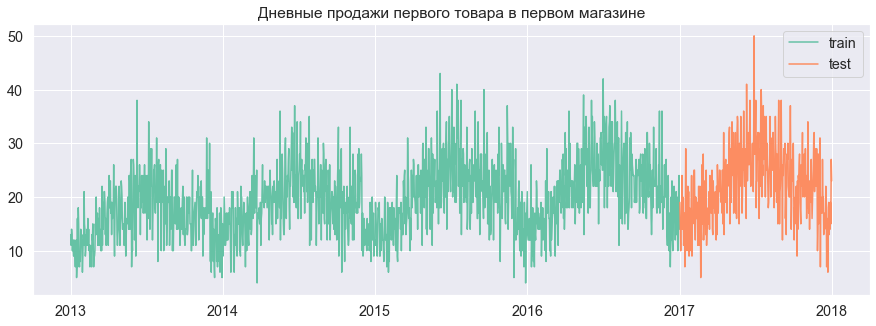

In [11]:
plt.figure(figsize=(15, 5))
plt.title("Дневные продажи первого товара в первом магазине")
plt.plot(train_ts, label="train")
plt.plot(test_ts, label="test")
plt.legend();

In [13]:
len(extract_hybrid_strategy_features(train_ts, 10))

110

In [83]:
datasets =  build_datasets(train_ts,extract_hybrid_strategy_features, 420, 20)

In [19]:
len(datasets)

20

In [29]:
pd.concat((pd.DataFrame(datasets[0][0]), pd.DataFrame(datasets[0][1])), axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,0
0,13,11,14,13,10,12,10,9,12,9,...,19,24,18,19,23,17,19,13,19,16
1,11,14,13,10,12,10,9,12,9,9,...,24,18,19,23,17,19,13,19,16,18
2,14,13,10,12,10,9,12,9,9,7,...,18,19,23,17,19,13,19,16,18,17
3,13,10,12,10,9,12,9,9,7,10,...,19,23,17,19,13,19,16,18,17,26
4,10,12,10,9,12,9,9,7,10,12,...,23,17,19,13,19,16,18,17,26,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,27,19,23,25,25,24,26,27,17,18,...,22,17,18,12,20,21,13,20,16,10
1357,19,23,25,25,24,26,27,17,18,27,...,17,18,12,20,21,13,20,16,10,16
1358,23,25,25,24,26,27,17,18,27,28,...,18,12,20,21,13,20,16,10,16,21
1359,25,25,24,26,27,17,18,27,28,23,...,12,20,21,13,20,16,10,16,21,24


In [84]:
models = train_models(train_ts, 20)

In [46]:
pred = predict(train_ts, models)
pred

2017-01-01    17.839067
2017-01-02    14.625583
2017-01-03    15.072114
2017-01-04    16.408716
2017-01-05    17.539839
2017-01-06    17.990213
2017-01-07    17.847943
2017-01-08    21.112281
2017-01-09    17.048063
2017-01-10    15.719395
2017-01-11    16.139944
2017-01-12    15.806072
2017-01-13    17.237780
2017-01-14    18.572654
2017-01-15    17.906371
2017-01-16    14.460712
2017-01-17    15.184904
2017-01-18    14.243900
2017-01-19    15.372826
2017-01-20    16.362828
dtype: float64

In [85]:
score_models(train_ts, test_ts, models, predict)

26.497759214454266

In [38]:
datasets =  build_datasets(train_ts,extract_hybrid_strategy_features, 364, 364)

In [39]:
models = train_models(train_ts, 364)

In [40]:
pred = predict(train_ts, models)

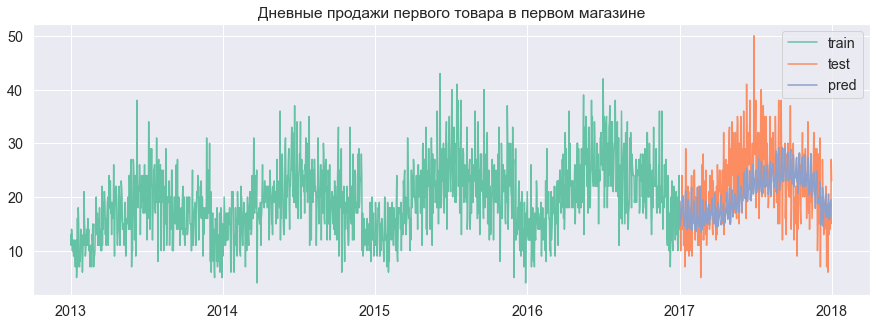

In [41]:
plt.figure(figsize=(15, 5))
plt.title("Дневные продажи первого товара в первом магазине")
plt.plot(train_ts, label="train")
plt.plot(test_ts, label="test")
plt.plot(pred, label='pred')
plt.legend();